<a href="https://colab.research.google.com/github/codewithAshwani/Text-to-Speech-Generation/blob/main/Extract__melspectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extract the melspectogram of MNIST digits.

In [ ]:
import os
import pickle
import librosa
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump
from pickle import load
import sounddevice as sd
import warnings
from phonemizer import phonemize
warnings.simplefilter("ignore", np.ComplexWarning)
FILES_DIR = '/path/recordings/'
SPECTROGRAMS_SAVE_DIR = '/path/feature_mel_all.pkl'

In [ ]:
def text_phonem(word):
  word = word.replace('-', '!') 
  phon_sente = phonemize(word, language='en-us',
                             backend='espeak',
                             strip=True,
                             preserve_punctuation=True,
                             with_stress=True,
                             njobs=4,
                             language_switch='remove-flags')
  phon_sente = phon_sente.replace('!','-') 
  return phon_sente

In [ ]:
##################################
#Read the wave file from FILES_DIR
#  and extracts spectrograms
##########################################
def extract(FILES_DIR, pickle_path, SAMPLE_RATE, DURATION, FRAME_SIZE,  HOP_LENGTH, MEL_CHANNELS, win_length):
    data = {
      "feauture_mfcc": [],
      "mapping": [],
      "phonem":[]
    }
    max_db = 100
    ref_db = 20
    num_samples = int(SAMPLE_RATE*DURATION)
    for i,filename in enumerate(os.listdir(FILES_DIR)):
            speaker = filename.split("_")[1]
            filepath = os.path.join(FILES_DIR, filename)  
            signal, _ = librosa.load(filepath, sr=SAMPLE_RATE, duration=DURATION)
            signal = librosa.util.normalize(signal)
#           signal,_ = librosa.effects.trim(signal, top_db=60, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH) 
            S = librosa.feature.melspectrogram(y=signal,sr=SAMPLE_RATE, power = 1,win_length=win_length, hop_length=HOP_LENGTH, n_fft=FRAME_SIZE,  n_mels=MEL_CHANNELS,   fmin=0, fmax=None)
            mel = 20 * np.log10(np.maximum(1e-5, S))
            mel = np.clip((mel - ref_db + max_db) / max_db, 1e-8, 1)
            mel = mel.T.astype(np.float32)  # (T, n_mels)
            label = filename.split("_")[0]
            label = int(label)
            data["feauture_mfcc"].append(mel)
            if label == 0:
                word = 'zero'
            if label == 1:
                word = 'one'
            if label == 2:
                word = 'two'
            if label == 3:
                word = 'three'
            if label == 4:
                word = 'four'
            if label == 5:
                word = 'five'
            if label == 6:
                word = 'six'
            if label == 7:
                word = 'seven'
            if label == 8:
                word = 'eight'
            if label == 9:
                word = 'nine'
            phonem_word = text_phonem(word)
            data["mapping"].append(word)
            data["phonem"].append(phonem_word)
    dump(data, open(pickle_path , 'wb'))

In [ ]:
FRAME_SIZE = 1024
HOP_LENGTH = 200
DURATION = 0.8  # in seconds
SAMPLE_RATE = 22050
MEL_CHANNELS = 60
win_length  =  1011
max_db = 100
ref_db = 20
power = 0.5
extract(FILES_DIR, SPECTROGRAMS_SAVE_DIR, SAMPLE_RATE, DURATION, FRAME_SIZE, HOP_LENGTH, MEL_CHANNELS, win_length)

In [ ]:
def load_features(filename):
    # load all features
    data = load(open(filename, 'rb'))

    datax = data["feauture_mfcc"]
    y = data["mapping"]
    phonem = data["phonem"]
    x_data = []
    for mel in datax:
        asd = mel.shape[1]
        start_vec = np.ones((1, asd))*0.5
        end_vec = np.ones((1, asd))*0.4
        norm_mel = np.concatenate([start_vec, mel, end_vec], axis=0)
        x_data.append(norm_mel)
        
    length = [x.shape[0] for x in x_data]
    
    pad_len = max([x.shape[0] for x in x_data])
    # padding to 2 seconds
    pad_arr = [np.pad(x, ((0, pad_len), (0, 0)), 'constant', constant_values=(0))[:pad_len, :] for x in x_data]

    
    return pad_arr,y,phonem, length
x,yx, phonem, length = load_features(SPECTROGRAMS_SAVE_DIR)

In [ ]:
x = np.array(x)
x.shape, yx[1], x.max(), x.min()

((83, 60), 0.8078133463859558)

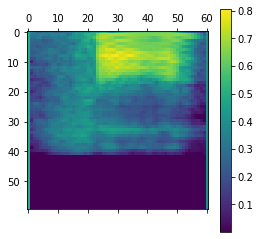

In [ ]:
####################################
#Example of Spectogram
####################################
plt.matshow(x[1][0:length[1],:].T)
plt.colorbar()
plt.show()

In [ ]:
#####################################
# Using Griffin-Lim reconstruction to convert
# mel spectrogram back into a waveform.
#####################################
def reconstruct_waveform(mel, n_iter=32, rate =1):
        """ Uses Griffin-Lim phase reconstruction to convert from a normalized
        mel spectrogram back into a waveform. """
        amp_mel = mel
        S = librosa.feature.inverse.mel_to_stft(
            amp_mel,
            power=1,
            sr=SAMPLE_RATE,
            n_fft=FRAME_SIZE,
            fmin=0,
            fmax=None)
        S_slow = librosa.core.phase_vocoder(S, rate=rate, hop_length=HOP_LENGTH)
        wav = librosa.core.griffinlim(
            S_slow,
            n_iter=n_iter,
            hop_length=HOP_LENGTH,
         win_length=win_length)
        return wav, S_slow

five
four
nine
six


(513, 83)

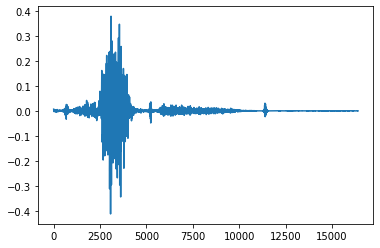

In [ ]:
####################################
#Example to convert Spectrogram to wav
#################################### 
# transpose
x1=np.copy(x[:,::1,:])
for i in range(4):
    mel = x1[i][1:-1,:].T

    # de-noramlize
    mel = (np.clip(mel, 0, 1) * max_db) - max_db + ref_db

    # to amplitude
    mel = np.power(10.0, mel * 0.05)

    # wav reconstruction
    y, S = reconstruct_waveform(mel)
    y1=librosa.effects.time_stretch(y, 1)
    print(yx[i])
    plt.plot(y1)
    plt.show()
    sd.play(y1, SAMPLE_RATE)
    time.sleep(0.5)    